In [1]:
%matplotlib inline
import numpy as np
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import matplotlib.pyplot as plt

from fuel.datasets.hdf5 import H5PYDataset

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from IPython.display import display

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Activation, Dropout
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [2]:
ftrain = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('train',))
X_train, y_train = ftrain.get_data(ftrain.open(), slice(0, ftrain.num_examples))
X_train = np.moveaxis(X_train[:], 1, 3)

ftest = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('test',))
X_test, y_test = ftest.get_data(ftest.open(), slice(0, ftest.num_examples))
X_test = np.moveaxis(X_test[:], 1, 3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


# Train PCA

In [3]:
n_components=500
pca = PCA(n_components=n_components, whiten=False)

start = time.time()

# Reshape to 1-D array
shape = X_train.shape
X_reshape = X_train.reshape((shape[0], -1)) / 255.
X_reshape.shape

pca.fit(X_reshape)
X_pca = pca.transform(X_reshape)

end = time.time()
elapsed = end - start
print('Fit time elapsed: {}'.format(elapsed))

pca

Fit time elapsed: 29.061871767044067


PCA(copy=True, iterated_power='auto', n_components=500, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [4]:
def display_grid(dataset, digit_size=32, grid_size=5, seed=None):
    # Display some digits to figure out what's going on
    figure = np.zeros((digit_size * grid_size, digit_size * grid_size, 3))
   
    if seed is not None:
        np.random.seed(seed)
    for i in range(grid_size):
        for j in range(grid_size):
            digit = dataset[np.random.randint(len(dataset))]
            d_x, d_y = i * digit_size, j * digit_size
            figure[d_x:d_x + digit_size, d_y:d_y + digit_size, :] = digit / 255.
            
    plt.figure(figsize=(5, 5))
    plt.imshow(figure)
    plt.show()

Originals


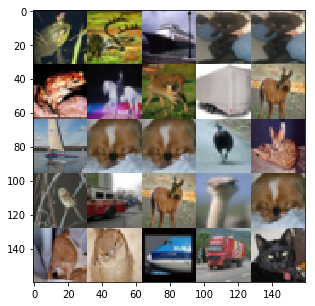

Reconstructed PCA


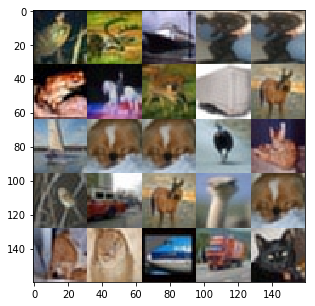

In [5]:
print("Originals")
sample_size = 100
index = np.random.choice(len(X_test), sample_size, replace=False)
X_display = X_test[index]
display_grid(X_display, seed=0)

print("Reconstructed PCA")
X_reshape = X_display.reshape((X_display.shape[0], -1)) / 255.
X_pca = pca.transform(X_reshape)
X_recon = np.clip(pca.inverse_transform(X_pca), 0.0, 0.999)
X_recon_reshape = X_recon.reshape(X_display.shape) * 255.
display_grid(X_recon_reshape, seed=0)

# Train model

In [6]:
X_test_pca = pca.transform(X_test.reshape((X_test.shape[0], -1)) / 255.)
results = []
for sample_size in [1000, 2000, 5000, 10000, 25000, 50000]:
    start = time.time()
    print('Fitting with sample_size: {}'.format(sample_size))
    model = SVC()
   
    if sample_size < len(X_train):
        sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(X_train), random_state=0)
        _, index = sss.split(X_train, y_train)
        X, y = X_train[index[1]], y_train[index[1]]
    else:
        X, y = X_train, y_train
    
    X_reshape = X.reshape((X.shape[0], -1)) / 255.
    X_pca = pca.transform(X_reshape)
    model.fit(X_pca, y.ravel())
    
    y_pred = model.predict(X_test_pca)
    score = accuracy_score(y_test, y_pred)
    
    end = time.time()
    elapsed = end - start
    print(' * Accuracy: %.1f %%' % (100. * score))
    print(' * Fit time elapsed: %.1fs' % elapsed)
    results.append({'sample_size': sample_size, 'accuracy': score, 'time': elapsed})

Fitting with sample_size: 1000
 * Accuracy: 35.6 %
 * Fit time elapsed: 5.6s
Fitting with sample_size: 2000
 * Accuracy: 38.4 %
 * Fit time elapsed: 11.4s
Fitting with sample_size: 5000
 * Accuracy: 42.0 %
 * Fit time elapsed: 36.9s
Fitting with sample_size: 10000
 * Accuracy: 44.6 %
 * Fit time elapsed: 101.0s
Fitting with sample_size: 25000
 * Accuracy: 48.2 %
 * Fit time elapsed: 440.2s
Fitting with sample_size: 50000
 * Accuracy: 50.7 %
 * Fit time elapsed: 1433.6s


In [7]:
df = pd.DataFrame(results)
display(df)
df.to_csv('pca_results.csv', index=False)

,accuracy,sample_size,time
0,0.3557,1000,5.637075
1,0.3835,2000,11.423495
2,0.4202,5000,36.890922
3,0.4465,10000,101.031454
4,0.4819,25000,440.231332
5,0.5068,50000,1433.566434
